In [1]:
import cv2
import numpy as np
import pywt
import time
from math import floor
import matplotlib.pyplot as plt
import pydicom

In [2]:
def embed_image(img, wm, q, wavelet='haar'):
    """Embeds a watermark into an image using DWT and SVD.

    Args:
        img (numpy.ndarray): The original image (YCrCb color space).
        wm (numpy.ndarray): The watermark image (grayscale).
        q (int): The watermark strength factor.
        wavelet (str, optional): The wavelet type for DWT. Defaults to 'haar'.

    Returns:
        numpy.ndarray: The watermarked image (BGR color space).
    """

    # Extract Y (luminance) component and perform DWT
    LL, (HL, LH, HH) = pywt.dwt2(img, wavelet)
    LL_embedded = embed_subband(LL, wm, q)
    img_embedded = pywt.idwt2((LL_embedded, (HL, LH, HH)), wavelet)
    return img_embedded

def embed_subband(split, wm, Q):
    """Embeds watermark into a DWT subband using SVD.

    Args:
        split (numpy.ndarray): The DWT subband.
        wm (numpy.ndarray): The watermark image.
        Q (int): The watermark strength factor.

    Returns:
        numpy.ndarray: The watermarked subband.
    """

    h, w = split.shape
    for i in range(h // 4):
        for j in range(w // 4):
            u, s, v = np.linalg.svd(np.float32(split[i*4:(i+1)*4, j*4:(j+1)*4]))
            s_max = int(s[0])
            a = np.mod(s_max, Q)

            if wm[i, j] == 0:
                s_max = s_max - a + (Q // 4 if 0 <= a < 3 * Q / 4 else 5 * Q // 4)
            elif wm[i, j] == 255:
                s_max = s_max - a - (Q // 4 if 0 <= a < Q // 4 else -3 * Q // 4)

            s[0] = s_max
            split[i*4:(i+1)*4, j*4:(j+1)*4] = np.dot(np.dot(u, np.diag(s)), v)
    return split


In [3]:
def extract_watermark(img, q, wavelet='haar'):
    """Extracts a watermark from a DICOM image using DWT and SVD.

    Args:
        img (numpy.ndarray): The watermarked DICOM image.
        q (int): The watermark strength factor (used during embedding).
        wavelet (str, optional): The wavelet type used for DWT during embedding. Defaults to 'haar'.

    Returns:
        numpy.ndarray: The extracted watermark image (binary).
    """
    LL, _ = pywt.dwt2(img, wavelet)  # Directly use the DICOM image (no Y channel extraction)
    extracted_wm = extract_from_subband(LL, q)
    return extracted_wm

def extract_from_subband(split, Q):
    """Extracts watermark from a DWT subband using SVD.

    Args:
        split (numpy.ndarray): The DWT subband.
        Q (int): The watermark strength factor.

    Returns:
        numpy.ndarray: The extracted watermark.
    """

    h, w = split.shape
    extracted_wm = []
    for i in range(h // 4):
        for j in range(w // 4):
            _, s, _ = np.linalg.svd(np.float32(split[i*4:(i+1)*4, j*4:(j+1)*4]))
            a = np.mod(s[0], Q)
            extracted_wm.append(1 if a > Q / 2 else 0)
    return np.array(extracted_wm).reshape((64, 64))  # Assuming 64x64 watermark


In [4]:
def load_dicom(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array
    return image, ds

def save_dicom(path, image, original_dicom):
    original_dicom.PixelData = image.astype(np.uint16).tobytes()
    original_dicom.save_as(path)

## Embed

./data/medical-img.dcm


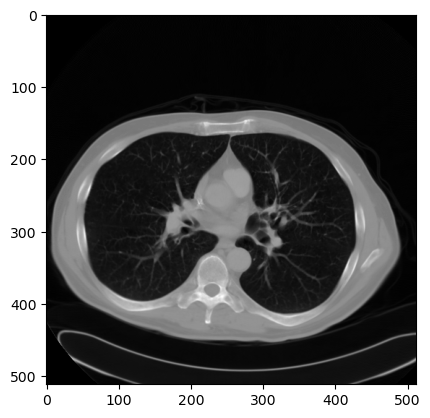

In [5]:
##EMBED
DATA_DIR = './data/'
OUTPUT_DIR = './watermarked_image/'
IMG_NAME = 'medical-img.dcm'
WM_NAME = 'wm.png'
Q = 50  # Watermark strength factor

# Load images
print(DATA_DIR+IMG_NAME)

dicom_image, ds = load_dicom(DATA_DIR+IMG_NAME)

#ori_img = cv2.imread(DATA_DIR + IMG_NAME)
#img_ycrcb = cv2.cvtColor(ori_img, cv2.COLOR_BGR2YCrCb)
wm = cv2.imread(DATA_DIR + WM_NAME, cv2.IMREAD_GRAYSCALE)

# Embed watermark and save
watermarked_img = embed_image(dicom_image, wm, Q)
#cv2.imwrite(OUTPUT_DIR + 'dwt_' + IMG_NAME, watermarked_img)
watermarked_img = np.clip(watermarked_img, ds.pixel_array.min(), ds.pixel_array.max())
save_dicom(OUTPUT_DIR + IMG_NAME, watermarked_img, ds)

# Display watermarked image (optional)
plt.imshow(watermarked_img, cmap='gray')
plt.show()

## EXTRACT

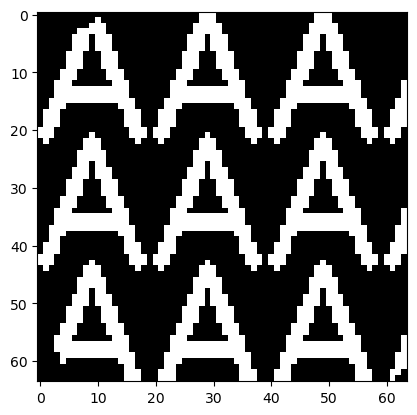

True

In [6]:
##EXTRACT WATERMARKED IMAGE
EXTRACT_WATERMARK_DIR = './extract_image/'

watermarked_dicom, _ = load_dicom(OUTPUT_DIR+IMG_NAME)

#ex_img = cv2.imread(OUTPUT_DIR + 'dwt_' + IMG_NAME) 
#ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2YCrCb) 

extracted_wm = extract_watermark(watermarked_dicom, Q) 

# Display the extracted watermark

plt.imshow(extracted_wm, cmap='gray')
plt.show()

# Save extracted watermark
output_wm_path = EXTRACT_WATERMARK_DIR + 'extracted_watermark.png'  # Or any desired format
cv2.imwrite(output_wm_path, extracted_wm * 255)  # Scale to 0-255

## GENERATE WATERMARK (NOT YET COMPLETED)

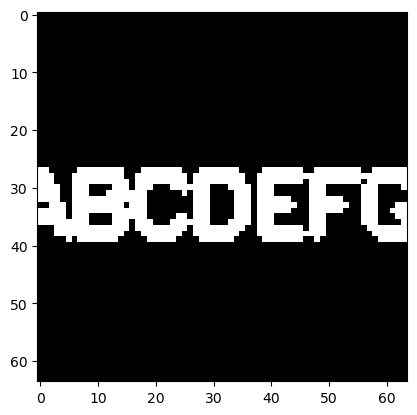

In [46]:
def generate_watermark(text, size=(64, 64), depth=32, font_scale=0.5):
    """Generates a watermark image with text.

    Args:
        text (str): The text to embed in the watermark.
        size (tuple, optional): The dimensions of the watermark (width, height). Defaults to (64, 64).
        depth (int, optional): The bit depth of the watermark image. Defaults to 32.
        font_scale (float, optional): The scale factor for the font size. Defaults to 0.5.

    Returns:
        numpy.ndarray: The generated watermark image.
    """

    wm = np.zeros(size, dtype=np.float32)  # Use float32 for 32-bit depth

    # Calculate text position (centered)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(text, font, font_scale, 2)[0] # Adjust font scale here
    x = (size[0] - text_size[0]) // 2
    y = (size[1] + text_size[1]) // 2

    # Add text to the image
    cv2.putText(wm, text, (x, y), font, font_scale, (1.0), 2, cv2.LINE_AA) # Adjust font scale here

    # Normalize pixel values to [0, 1]
    wm /= wm.max()  

    return wm

# Example usage
text = "ABCDEFG"
watermark_size = (64, 64)
bit_depth = 32
font_scale = 0.5  # Smaller font scale
watermark_image = generate_watermark(text, watermark_size, bit_depth, font_scale)

# Save watermark
cv2.imwrite("watermark.png", watermark_image * 255)

# Display watermark (optional)
import matplotlib.pyplot as plt
plt.imshow(watermark_image, cmap='gray')
plt.show()

In [61]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, normalized_root_mse

def evaluate_metrics(original_image, watermarked_img):
    
    # PSNR
    psnr = cv2.PSNR(original_image.astype(np.float32), watermarked_img.astype(np.float32))

    # SSIM
    ssim = structural_similarity(original_image, watermarked_img, data_range=1)

    # NCM (Normalized Cross-Correlation)
    nc = np.corrcoef(original_image.ravel(), watermarked_img.ravel())[0, 1]

    return psnr, ssim, nc

In [62]:
psnr, ssim, nc = evaluate_metrics(dicom_image.astype(np.float32), watermarked_img.astype(np.float32))
print(f"PSNR: {psnr:.2f}, SSIM: {ssim:.2f}, NC: {ncm:.2f}")


PSNR: 43.06, SSIM: 0.97, NC: 0.00


In [48]:


def calculate_ber(original_wm, extracted_wm):
    # Calculate BER
    ber = np.sum(np.abs(extracted_wm - original_wm)) / (
        original_wm.shape[0] * original_wm.shape[1]
    )

    return ber


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_ubyte
from skimage.filters import gaussian, median
from skimage.util import random_noise
from skimage.transform import resize
from skimage.io import imsave, imread
from io import BytesIO
from PIL import Image

def apply_attacks_and_extract(dicom_image, extract_function, original_watermark):
    image = img_as_float(dicom_image.copy())  # Ensure image is in the right format for attacks
    original_watermark = img_as_float(original_watermark)

    attacked_images = apply_attacks(image)
    extracted_watermarks = {}

    for name, attacked_img in attacked_images.items():
        # Resize the attacked image to match the size of the original image
        extracted_watermarks[name] = extract_function(img_as_float(attacked_img), 50)

        # Evaluate metrics
        ber = calculate_ber(original_watermark, extracted_watermarks[name])
        print(f"BER: {ber:.4f}")

    num_attacks = len(attacked_images)
    fig, axs = plt.subplots(num_attacks, 2, figsize=(10, 2 * num_attacks))

    for i, (attack_name, attacked_img) in enumerate(attacked_images.items()):
        axs[i, 0].imshow(attacked_img, cmap='gray')
        axs[i, 0].set_title(f"{attack_name} - Attacked")
        axs[i, 0].axis('off')

        if extracted_watermarks.get(attack_name) is not None:
            axs[i, 1].imshow(extracted_watermarks[attack_name], cmap='gray')
            axs[i, 1].set_title(f"{attack_name} - Extracted")
            axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

def apply_attacks(image):
    attacks = {
        "Without Attack": lambda x: x,
        "Minimal Gaussian Blur": lambda x: gaussian(x, sigma=1),
        "Moderate Gaussian Blur": lambda x: gaussian(x, sigma=2),
        "Median Filtering": lambda x: median(x),
        "JPEG Compression - Low": lambda x: jpeg_compression(x, quality=85),
        "JPEG Compression - High": lambda x: jpeg_compression(x, quality=50),
        "Scaling Attack - Down & Up": lambda x: scale_down_up(x),
        "Very Light Smoothing": lambda x: gaussian(x, sigma=0.5)
    }

    attacked_images = {}
    for name, attack_func in attacks.items():
        attacked_images[name] = attack_func(image.copy())

    return attacked_images

import cv2
import numpy as np

def jpeg_compression(dicom_image, quality=85):
    # Check if the image is already in 8-bit format, if not, normalize and convert
    if dicom_image.dtype != np.uint8:
        # Normalize the image to 0-255 range
        max_value = np.max(dicom_image)
        min_value = np.min(dicom_image)
        normalized_image = 255 * (dicom_image - min_value) / (max_value - min_value)
        image_8bit = normalized_image.astype(np.uint8)
    else:
        image_8bit = dicom_image

    # Set JPEG quality level for compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encoded_image = cv2.imencode('.jpg', image_8bit, encode_param)
    if result:
        decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_UNCHANGED)

        # Check if color conversion is necessary (if original was color, convert back to grayscale)
        if len(decoded_image.shape) == 3 and decoded_image.shape[2] == 3:
            decoded_image = cv2.cvtColor(decoded_image, cv2.COLOR_BGR2GRAY)
        return decoded_image
    else:
        raise Exception("Image encoding failed.")


def scale_down_up(image, scale_factor=0.5):
    height, width = image.shape[:2]
    resized_down = resize(image, (int(height * scale_factor), int(width * scale_factor)), anti_aliasing=True)
    resized_up = resize(resized_down, (height, width), anti_aliasing=True)
    return resized_up


262144 262144
Without Attack - PSNR: 361.20, SSIM: 1.00, NCM: 0.00, BER: 0.3274
262144 262144
Minimal Gaussian Blur - PSNR: 115.48, SSIM: 1.00, NCM: 0.05, BER: 0.3274
262144 262144
Moderate Gaussian Blur - PSNR: 109.04, SSIM: 1.00, NCM: 0.11, BER: 0.3274
262144 262144
Median Filtering - PSNR: 120.63, SSIM: 1.00, NCM: 0.03, BER: 0.3274
262144 262144
JPEG Compression - Low - PSNR: 11.02, SSIM: 0.02, NCM: 8674.42, BER: 0.3274
262144 262144
JPEG Compression - High - PSNR: 11.02, SSIM: 0.02, NCM: 8674.47, BER: 0.3274
262144 262144
Scaling Attack - Down & Up - PSNR: 114.18, SSIM: 1.00, NCM: 0.06, BER: 0.3274
262144 262144
Very Light Smoothing - PSNR: 125.74, SSIM: 1.00, NCM: 0.02, BER: 0.3274


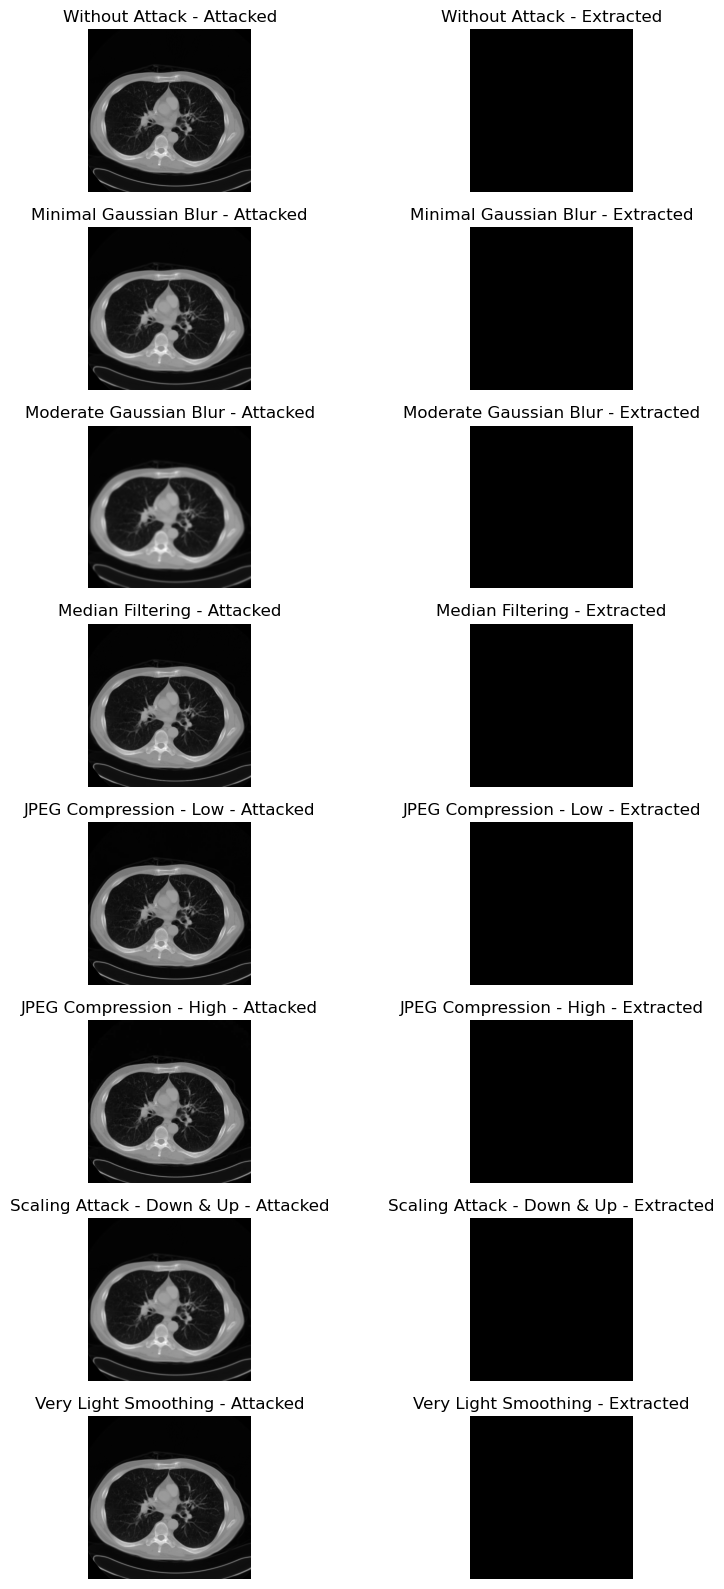

In [52]:
apply_attacks_and_extract(dicom_image, extract_watermark, wm)